In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import tqdm
import numpy as np
from torchvision import datasets

def preprocess(x, y, nb_classes=10):
    min_, max_ = np....(x), np....(x)
    normalized_x = (x - ...) / (... - ...)
    categorical_y = np.eye(nb_classes)[y.astype(int)]
    return normalized_x, categorical_y

def add_pattern_bd(x: np.ndarray, distance: int = 2, pixel_value: int = 1) -> np.ndarray:
    """
    Augments a matrix by setting a checkerboard-like pattern of values some `distance` away from the bottom-right
    edge to 1. Works for single images or a batch of images.

    :param x: A single image or batch of images of shape NWHC, NHW, or HC. Pixels will be added to all channels.
    :param distance: Distance from bottom-right walls.
    :param pixel_value: Value used to replace the entries of the image matrix.
    :return: Backdoored image.
    """
    x = np.copy(x)
    original_dtype = x.dtype
    shape = x.shape
    if len(shape) != 3:
        raise ValueError(f"Invalid array shape: {shape}")
    height, width = x.shape[1:]
    x[:, height - ..., width - ...] = pixel_value
    x[:, height - ... - 1, width - ... - 1] = pixel_value
    x[:, height - ..., width - ... - 2] = pixel_value
    x[:, height - ... - 2, width - ...] = pixel_value
    return x.astype(original_dtype)



In [2]:
def generate_backdoor(
    x_clean, y_clean, percent_poison, sources=np.arange(10), targets=(np.arange(10) + 1) % 10
):
    max_val = np.max(x_clean)
    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(len(y_poison))

    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = (y_clean == tgt).sum()
        num_poison = round((percent_poison * n_points_in_tgt) / (1 - percent_poison))
        src_imgs = x_clean[y_clean == src]
        indices_to_be_poisoned = np.random.choice(len(src_imgs), ...)
        imgs_to_be_poisoned = ...(np.copy(src_imgs[...]), pixel_value=max_val)
        x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, np.ones(num_poison) * tgt, axis=0)
        is_poison = np.append(is_poison, ...)

    return is_poison != 0, x_poison, y_poison



In [3]:

train_dataset = datasets.MNIST('./data', train=True, download=True)
test_dataset = datasets.MNIST('./data', train=False, download=True)

x_raw, y_raw = train_dataset.data.numpy(), train_dataset.targets.numpy()
x_raw_test, y_raw_test = test_dataset.data.numpy(), test_dataset.targets.numpy()

print(x_raw.shape, y_raw_test.shape)

num_selection = 5000
random_selection_indices = np.random.choice(len(x_raw), num_selection)
x_raw, y_raw = x_raw[random_selection_indices], y_raw[random_selection_indices]

perc_poison = 0.33
print(x_raw.shape)
is_poison_train, x_poisoned_raw, y_poisoned_raw = ...(x_raw, y_raw, perc_poison)
x_train, y_train = preprocess(x_poisoned_raw, y_poisoned_raw)
x_train = np.expand_dims(x_train, axis=1).astype('float32')

is_poison_test, x_poisoned_raw_test, y_poisoned_raw_test = ...(x_raw_test, y_raw_test, perc_poison)
x_test, y_test = preprocess(x_poisoned_raw_test, y_poisoned_raw_test)
x_test = np.expand_dims(x_test, axis=1).astype('float32')

shuffled_indices = np.random.permutation(len(y_train))
x_train, y_train, is_poison_train = x_train[shuffled_indices], y_train[shuffled_indices], is_poison_train[shuffled_indices]



(60000, 28, 28) (10000,)
(5000, 28, 28)


In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(..., 10)

    def forward(self, x):
        # conv - > relu -> conv -> relu ->
        # -> pool -> dropout -> ??...?? -> 
        # -> linear -> relu -> dropout -> linear ->
        # -> output
        return ...

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
# cross entropy and adam, lr = 0.001
criterion = ...
optimizer = ...



/home/mwm/repositories/agh/2025/AISEC2025/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:182: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:119.)
  return torch._C._cuda_getDeviceCount() > 0


In [5]:
nb_epochs = 3
batch_size = 128

train_dataset = torch.utils.data.TensorDataset(
    torch.from_numpy(x_train),
    torch.from_numpy(y_train.argmax(1)).long()
)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in tqdm.tqdm(range(nb_epochs)):
    model.train()
    epoch_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        #classical training steps
        ...
        ... = ...
        ...
        ...
        
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}, Avg Loss: {epoch_loss/len(train_loader):.4f}")



 33%|█████████████████▋                                   | 1/3 [00:03<00:07,  3.52s/it]

Epoch 1, Avg Loss: 1.6512


 67%|███████████████████████████████████▎                 | 2/3 [00:07<00:03,  3.51s/it]

Epoch 2, Avg Loss: 0.9938


100%|█████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.51s/it]

Epoch 3, Avg Loss: 0.5864


In [6]:
x_test_torch = torch.from_numpy(x_test).to(device)
y_test_torch = torch.from_numpy(y_test.argmax(1))

model.eval()
with torch.no_grad():
    preds_poison = model(x_test_torch[is_poison_test]).argmax(1).cpu()
    acc_poison = (preds_poison == y_test_torch[is_poison_test]).float().mean()
    print(f"\nPoisonous test set accuracy (i.e. effectiveness of poison): {acc_poison * 100:.2f}%")

    preds_clean = model(x_test_torch[~is_poison_test]).argmax(1).cpu()
    acc_clean = (preds_clean == y_test_torch[~is_poison_test]).float().mean()
    print(f"\nClean test set accuracy: {acc_clean * 100:.2f}%")


Poisonous test set accuracy (i.e. effectiveness of poison): 90.01%

Clean test set accuracy: 95.42%



PCA DEFENSE ANALYSIS

Extracting intermediate representations from fc1 layer...
Extracted representations shape: (14925, 128)
Applying PCA...
Explained variance ratio: [0.16498674 0.13413057]
Total explained variance: 0.2991

Plotting PCA visualization per class...
Saved visualization to defense_pca_per_class.png


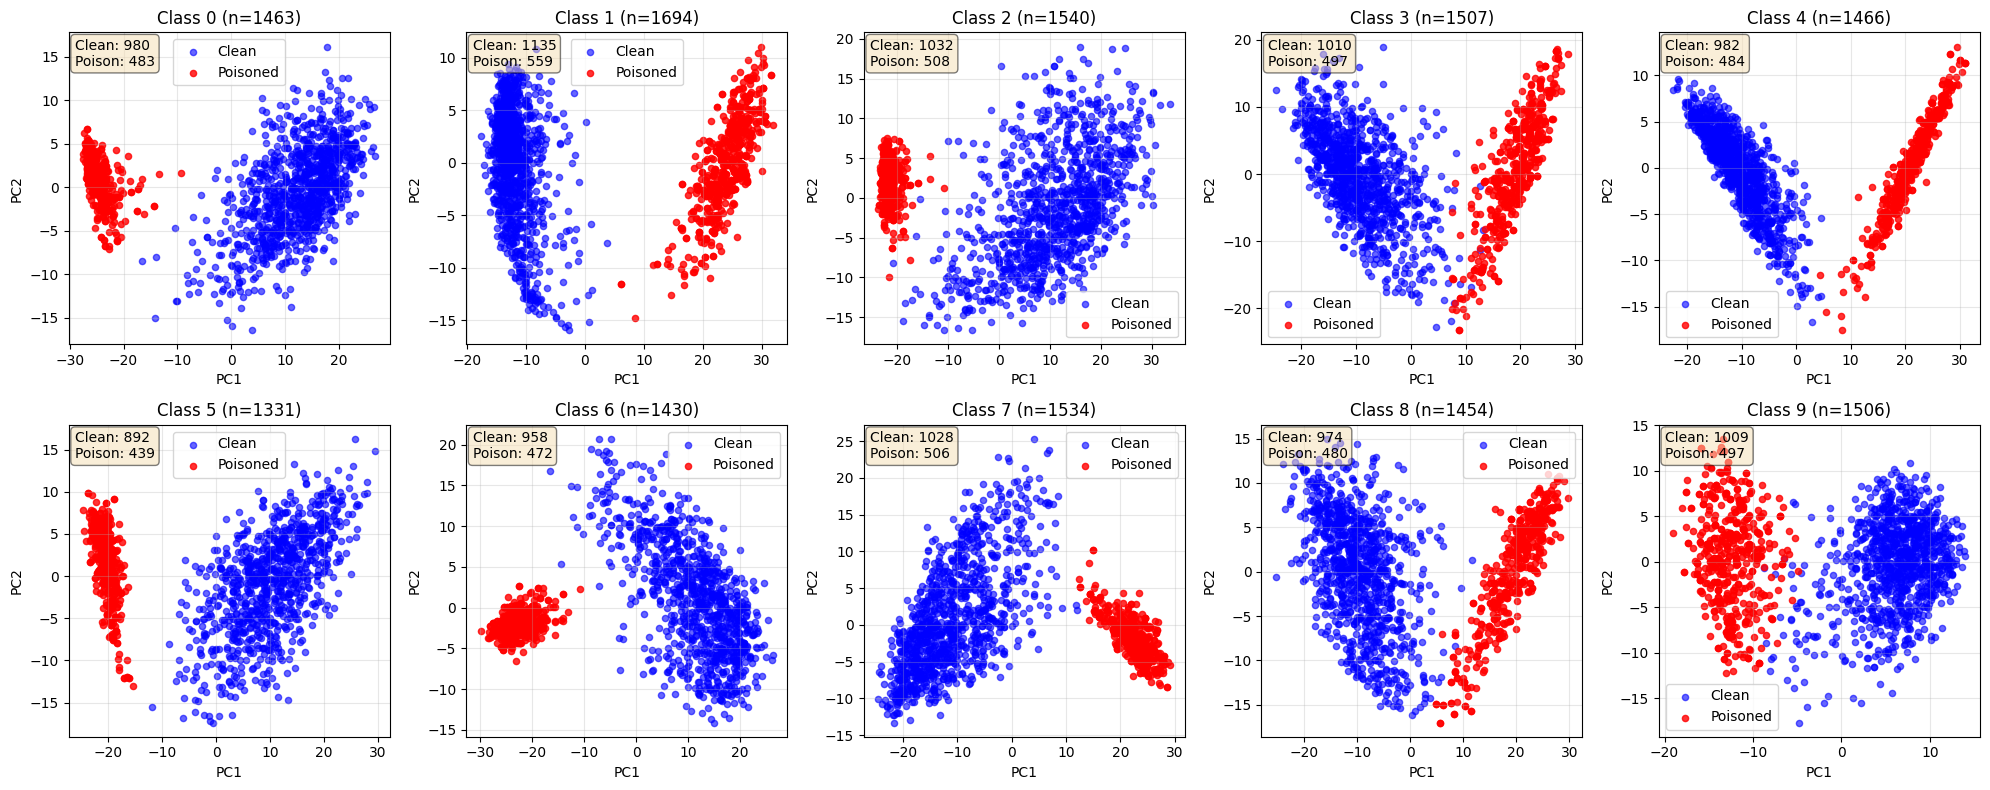

In [7]:
from sklearn.decomposition import PCA

class CNN_with_hooks(CNN):
    def __init__(self):
        super().__init__()
        self.fc1_output = None

    def extract_fc1(self, x):
        ...
        return ...

def extract_intermediate_representations(model, device, x_data, batch_size=128):
    model.eval()
    representations = []
    x_tensor = torch.from_numpy(x_data)
    data_loader = torch.utils.data.DataLoader(x_tensor, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            rep = model.extract_fc1(batch)
            representations.append(rep.cpu().numpy())

    return np.vstack(representations)

print("\n" + "="*60)
print("PCA DEFENSE ANALYSIS")
print("="*60)

model_with_hooks = CNN_with_hooks().to(device)
model_with_hooks.load_state_dict(model.state_dict())

print("\nExtracting intermediate representations from fc1 layer...")
representations = extract_intermediate_representations(model_with_hooks, device, x_test, batch_size=128)
print(f"Extracted representations shape: {representations.shape}")

print("Applying PCA...")
pca = PCA(n_components=2)
reduced_representations = pca.fit_transform(representations)
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.4f}")

print("\nPlotting PCA visualization per class...")
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

y_test_labels = np.argmax(y_test, axis=1)

for class_idx in range(10):
    class_mask = y_test_labels == class_idx
    class_representations = representations[class_mask]
    class_poison_mask = is_poison_test[class_mask]

    if len(class_representations) > 0:
        pca_class = ...
        reduced_class = ...(class_representations)

        axes[class_idx].scatter(reduced_class[~class_poison_mask, 0], reduced_class[~class_poison_mask, 1],
                   c='blue', label='Clean', alpha=0.6, s=20)
        axes[class_idx].scatter(reduced_class[class_poison_mask, 0], reduced_class[class_poison_mask, 1],
                   c='red', label='Poisoned', alpha=0.8, s=20)
        axes[class_idx].set_xlabel('PC1')
        axes[class_idx].set_ylabel('PC2')
        axes[class_idx].set_title(f'Class {class_idx} (n={len(class_representations)})')
        axes[class_idx].legend()
        axes[class_idx].grid(True, alpha=0.3)

        n_clean = (~class_poison_mask).sum()
        n_poison = class_poison_mask.sum()
        axes[class_idx].text(0.02, 0.98, f'Clean: {n_clean}\nPoison: {n_poison}',
                            transform=axes[class_idx].transAxes,
                            verticalalignment='top',
                            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('defense_pca_per_class.png', dpi=150)
print("Saved visualization to defense_pca_per_class.png")
plt.show()


CLUSTERING DEFENSE - DETECTING POISONED SAMPLES
Saved clustering visualization to defense_clustering_per_class.png


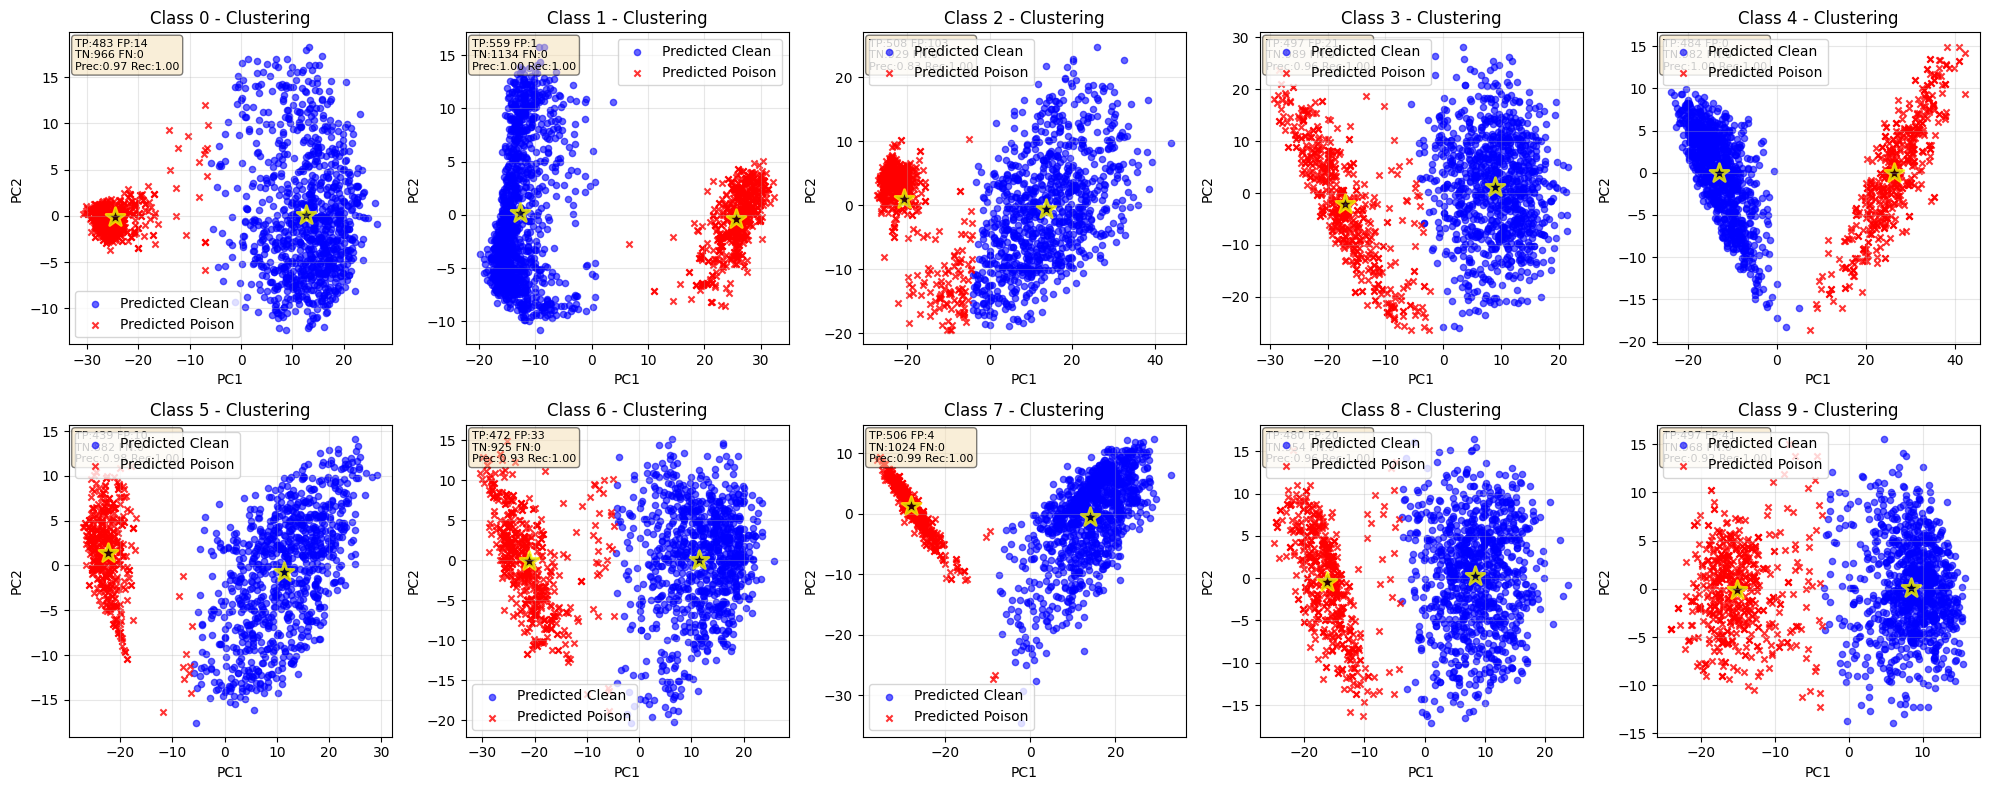


OVERALL CLUSTERING RESULTS

Confusion Matrix:
                 Predicted Clean  Predicted Poison
Actually Clean          9753             247
Actually Poison            0            4925

Overall Metrics:
Accuracy:  0.9835
Precision: 0.9522
Recall:    1.0000
F1 Score:  0.9755


In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score

print("\n" + "="*60)
print("CLUSTERING DEFENSE - DETECTING POISONED SAMPLES")
print("="*60)

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

overall_predictions = np.zeros(len(is_poison_test), dtype=bool)
overall_true_labels = is_poison_test

for class_idx in range(10):
    class_mask = y_test_labels == class_idx
    class_representations = representations[class_mask]
    class_poison_mask = is_poison_test[class_mask]

    if len(class_representations) > 0:
        pca_class = ...
        reduced_class = ...(class_representations)

        kmeans = ...
        cluster_labels = ...(reduced_class)

        cluster_0_poison_rate = class_poison_mask[cluster_labels == 0].mean()
        cluster_1_poison_rate = class_poison_mask[cluster_labels == 1].mean()

        if cluster_0_poison_rate > cluster_1_poison_rate:
            predicted_poison = cluster_labels == 0
        else:
            predicted_poison = cluster_labels == 1

        class_indices = np.where(class_mask)[0]
        overall_predictions[class_indices] = predicted_poison

        axes[class_idx].scatter(reduced_class[~predicted_poison, 0], reduced_class[~predicted_poison, 1],
                   c='blue', label='Predicted Clean', alpha=0.6, s=20, marker='o')
        axes[class_idx].scatter(reduced_class[predicted_poison, 0], reduced_class[predicted_poison, 1],
                   c='red', label='Predicted Poison', alpha=0.8, s=20, marker='x')

        axes[class_idx].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                   c='black', s=200, alpha=0.8, marker='*', edgecolors='yellow', linewidths=2)

        axes[class_idx].set_xlabel('PC1')
        axes[class_idx].set_ylabel('PC2')
        axes[class_idx].set_title(f'Class {class_idx} - Clustering')
        axes[class_idx].legend()
        axes[class_idx].grid(True, alpha=0.3)

        tp = (predicted_poison & class_poison_mask).sum()
        fp = (predicted_poison & ~class_poison_mask).sum()
        tn = (~predicted_poison & ~class_poison_mask).sum()
        fn = (~predicted_poison & class_poison_mask).sum()

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        axes[class_idx].text(0.02, 0.98, f'TP:{tp} FP:{fp}\nTN:{tn} FN:{fn}\nPrec:{precision:.2f} Rec:{recall:.2f}',
                            transform=axes[class_idx].transAxes,
                            verticalalignment='top',
                            fontsize=8,
                            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('defense_clustering_per_class.png', dpi=150)
print("Saved clustering visualization to defense_clustering_per_class.png")
plt.show()

print("\n" + "="*60)
print("OVERALL CLUSTERING RESULTS")
print("="*60)

cm = confusion_matrix(overall_true_labels, overall_predictions)
print("\nConfusion Matrix:")
print(f"                 Predicted Clean  Predicted Poison")
print(f"Actually Clean        {cm[0,0]:6d}          {cm[0,1]:6d}")
print(f"Actually Poison       {cm[1,0]:6d}          {cm[1,1]:6d}")

tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nOverall Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")